In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

data_path = './Dataset/'
data = pd.read_csv(data_path + 'hour.csv')

# EDA

In [214]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The following columns are instantly removed, because they either possess no ralationship to the data, like, 'instant', or will have very high correlation, in the example of 'casual' and 'registered' these data points if summed make up target variable.

In [215]:
to_drop = ['instant', 'dteday', 'casual', 'registered']

data = data.drop(to_drop, axis=1)

In [216]:
data.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [217]:
data.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [218]:
data.shape

(17379, 13)

## Visualizations

<Axes: xlabel='hr', ylabel='count'>

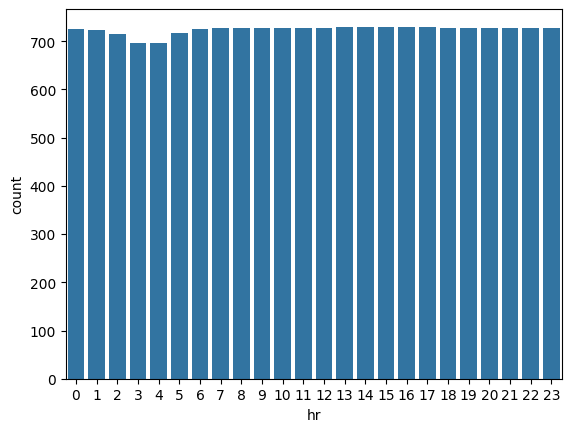

In [219]:
sns.countplot(x='hr', data=data)

<Axes: xlabel='workingday', ylabel='count'>

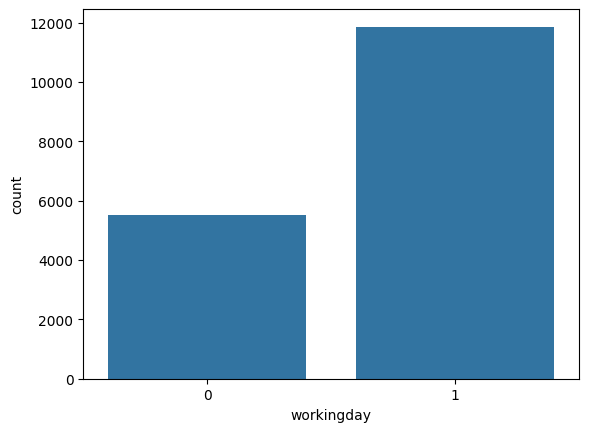

In [220]:
sns.countplot(x='workingday', data=data)

<Axes: xlabel='weekday', ylabel='count'>

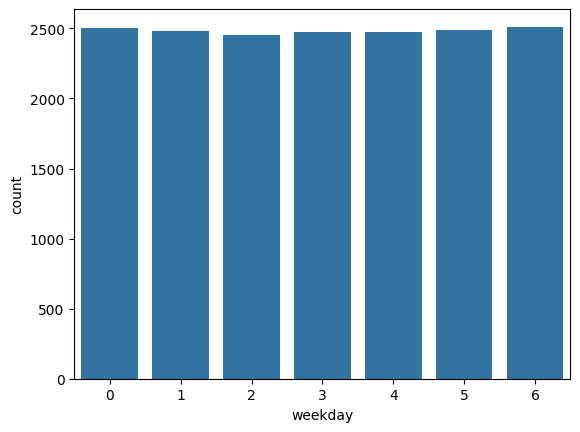

In [221]:
sns.countplot(x='weekday', data=data)

<Axes: xlabel='holiday', ylabel='count'>

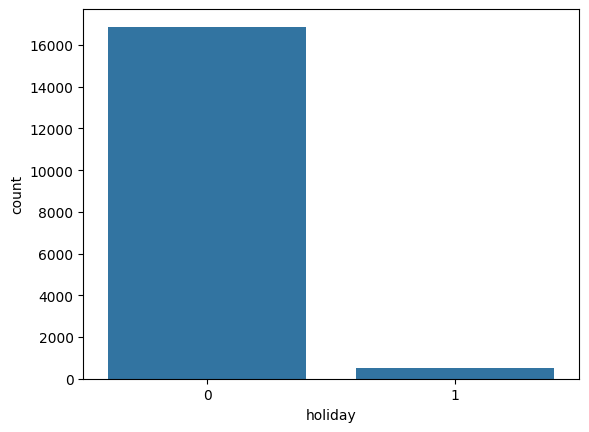

In [222]:
sns.countplot(x='holiday', data=data)

<Axes: xlabel='season', ylabel='count'>

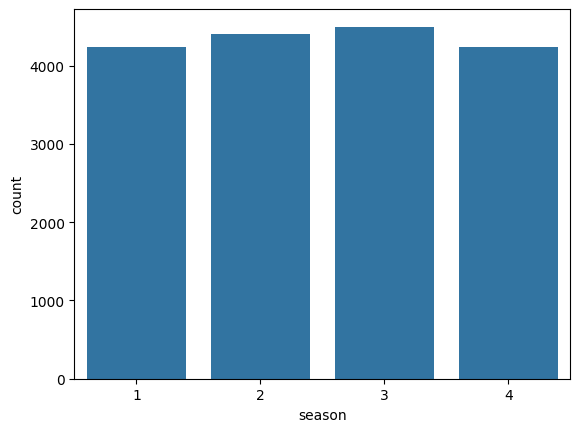

In [223]:
sns.countplot(x='season', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

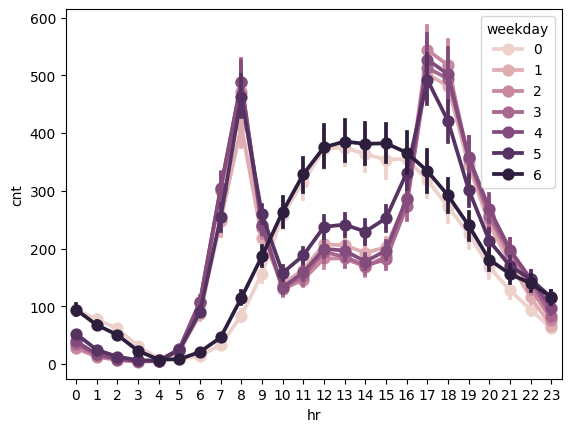

In [224]:
sns.pointplot(x='hr', y='cnt', hue='weekday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

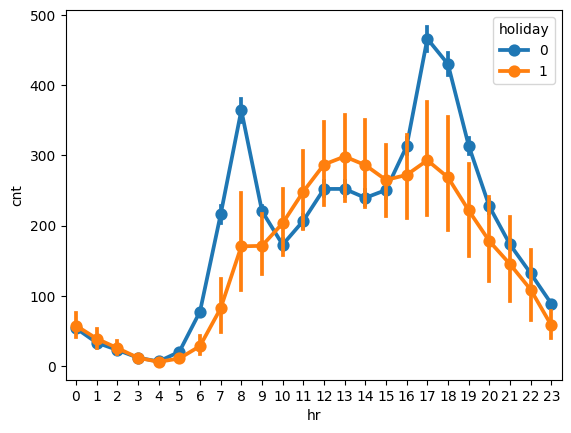

In [225]:
sns.pointplot(x='hr', y='cnt', hue='holiday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

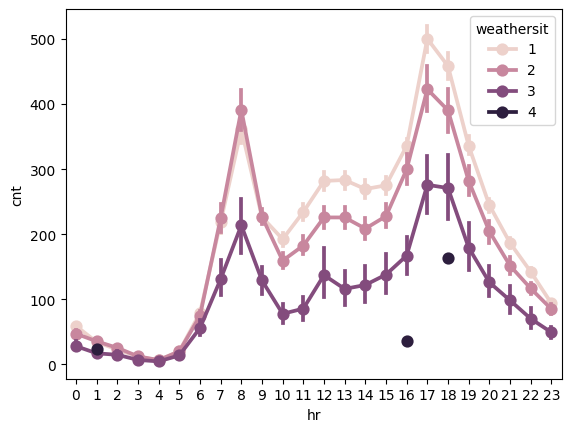

In [226]:
sns.pointplot(x='hr', y='cnt', hue='weathersit', data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

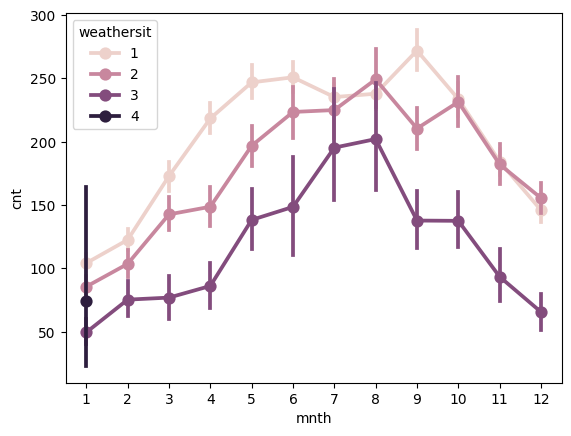

In [227]:
sns.pointplot(y='cnt', x='mnth', hue='weathersit', data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

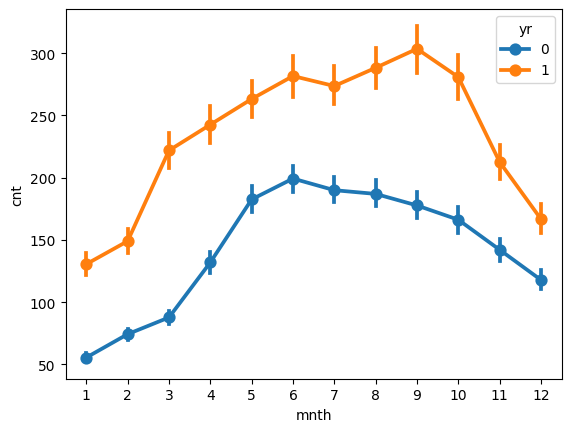

In [228]:
sns.pointplot(x='mnth', y='cnt', hue='yr', data=data)

## Correlation matrix

<Axes: >

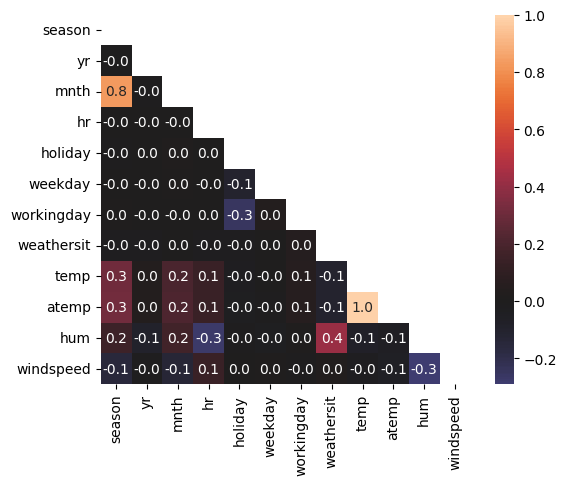

In [229]:
corr = data.loc[:,data.columns!='cnt'].corr(method="pearson")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    mask = mask,
    vmax=1,
    center=0,
    annot=True,
    fmt='.1f',
    square=True,
)

From correlation matrix it can be seen that there are dependent variables, which should be removed, like
temp and atemp


In [230]:
print(np.corrcoef(data['season'], data['cnt']))

print(np.corrcoef(data['mnth'], data['cnt']))


[[1.         0.17805573]
 [0.17805573 1.        ]]
[[1.         0.12063776]
 [0.12063776 1.        ]]


In [231]:
def one_hot_encoder(df,column):
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column)],axis=1)
    df = df.drop(columns = [column],axis=1)
    return df

ohe_columns = ['hr', 'mnth', 'holiday', 'season', 'weekday', 'workingday', 'weathersit']

for col in ohe_columns:
    data[col] = data[col].astype('category')


for col in ohe_columns:
    data = one_hot_encoder(data,col)

In [232]:
data.head()

,yr,temp,atemp,hum,windspeed,cnt,hr_0,hr_1,hr_2,hr_3,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0.24,0.2879,0.81,0.0,16,True,False,False,False,...,False,False,False,True,True,False,True,False,False,False
1,0,0.22,0.2727,0.80,0.0,40,False,True,False,False,...,False,False,False,True,True,False,True,False,False,False
2,0,0.22,0.2727,0.80,0.0,32,False,False,True,False,...,False,False,False,True,True,False,True,False,False,False
3,0,0.24,0.2879,0.75,0.0,13,False,False,False,True,...,False,False,False,True,True,False,True,False,False,False
4,0,0.24,0.2879,0.75,0.0,1,False,False,False,False,...,False,False,False,True,True,False,True,False,False,False


# Model Training

In [233]:
y = data.pop('cnt')

X = data.drop(columns=['temp','windspeed'],axis=1)

In [234]:
X.shape

(17379, 58)

In [235]:
X.columns

Index(['yr', 'atemp', 'hum', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'holiday_0', 'holiday_1', 'season_1', 'season_2', 'season_3',
       'season_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Linear Regression

In [237]:
lr = LinearRegression()

y_pred = cross_val_predict(lr, X,y,cv=5, n_jobs=-1)

In [238]:
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

print(f'Negative mean root squared error score with cross validation: {scores.mean():.3f}')

Negative mean root squared error score with cross validation: -11835.808


In [239]:
scores = cross_val_score(lr, X, y, cv=5, scoring='r2')

print(f'R2 score with cross validation: {scores.mean():.3f}')

R2 score with cross validation: 0.539


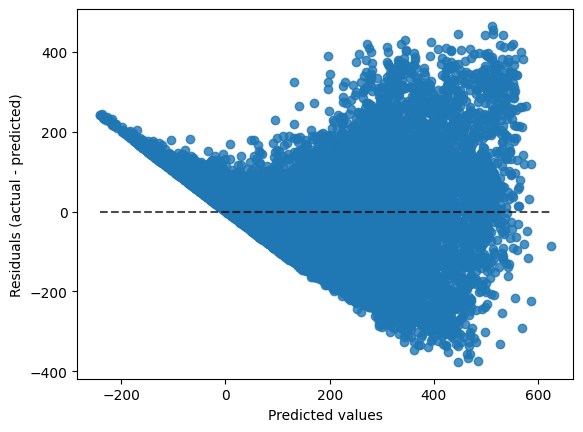

In [240]:
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

plt.show()

### Applying Standardization to columns with real data values

In [241]:
scaler = StandardScaler()

X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)

X_train_scaled['atemp'] = scaler.fit_transform(np.asarray(X_train['atemp']).reshape(-1, 1))
X_test_scaled['atemp'] = scaler.fit_transform(np.asarray(X_test['atemp']).reshape(-1, 1))

X_train_scaled['hum'] = scaler.fit_transform(np.asarray(X_train['hum']).reshape(-1, 1))
X_test_scaled['hum'] = scaler.fit_transform(np.asarray(X_test['hum']).reshape(-1, 1))

In [242]:
lr = LinearRegression()

y_pred = cross_val_predict(lr, X,y,cv=5, n_jobs=-1)

In [243]:
scores = cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

print(f'Negative mean root squared error score with cross validation: {scores.mean():.3f}')

Negative mean root squared error score with cross validation: -11835.808


In [244]:
scores = cross_val_score(lr, X, y, cv=5, scoring='r2')

print(f'R2 score with cross validation: {scores.mean():.3f}')

R2 score with cross validation: 0.539


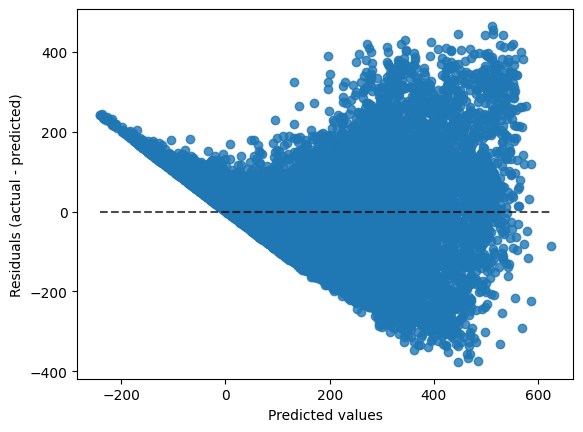

In [245]:
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

plt.show()

## SVM

In [246]:
svm = SVC(kernel='linear')

In [247]:
scores = cross_val_score(svm, X, y, cv=5, scoring='neg_mean_squared_error')

print(f'Negative mean root squared error score with cross validation: {scores.mean():.3f}')

c:\Users\vitalijs.tickovs\OneDrive - Accenture\Documents\Training\.conda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Negative mean root squared error score with cross validation: -15982.562


In [248]:
scores = cross_val_score(svm, X, y, cv=5, scoring='r2')

print(f'R2 score with cross validation: {scores.mean():.3f}')

c:\Users\vitalijs.tickovs\OneDrive - Accenture\Documents\Training\.conda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


R2 score with cross validation: 0.515


c:\Users\vitalijs.tickovs\OneDrive - Accenture\Documents\Training\.conda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


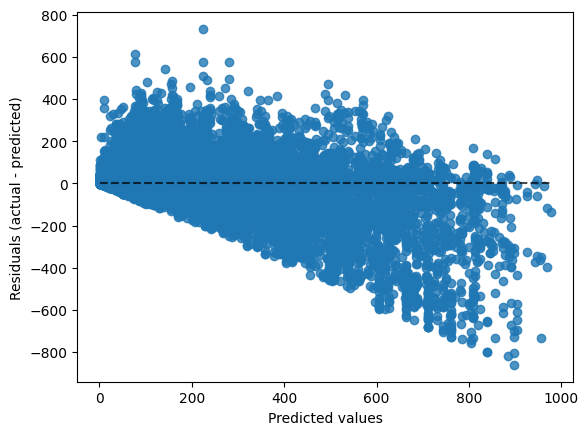

In [249]:
y_pred = cross_val_predict(svm, X, y, cv = 5, n_jobs=-1)

display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

plt.show()

## Random Forest

In [250]:
rf = RandomForestRegressor()

y_pred = cross_val_predict(rf, X,y, cv=5, n_jobs=-1)

In [251]:
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

print(f'Negative mean root squared error score with cross validation: {scores.mean():.3f}')

Negative mean root squared error score with cross validation: -5904.342


In [252]:
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')

print(f'R2 score with cross validation: {scores.mean():.3f}')

R2 score with cross validation: 0.767


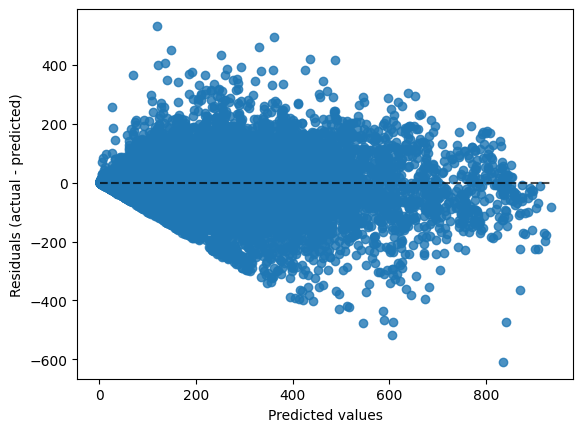

In [253]:
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

plt.show()

Epoch [1/100], Loss: 25525.0811
Epoch [2/100], Loss: 5585.1371
Epoch [3/100], Loss: 4123.6143
Epoch [4/100], Loss: 3385.0257
Epoch [5/100], Loss: 2980.3021
Epoch [6/100], Loss: 2758.5936
Epoch [7/100], Loss: 2561.2139
Epoch [8/100], Loss: 2466.2925
Epoch [9/100], Loss: 2369.8960
Epoch [10/100], Loss: 2290.0709
Epoch [11/100], Loss: 2226.6306
Epoch [12/100], Loss: 2161.6036
Epoch [13/100], Loss: 2105.5221
Epoch [14/100], Loss: 2059.4647
Epoch [15/100], Loss: 2007.3522
Epoch [16/100], Loss: 1950.8415
Epoch [17/100], Loss: 1921.9674
Epoch [18/100], Loss: 1860.7276
Epoch [19/100], Loss: 1826.2040
Epoch [20/100], Loss: 1769.4789
Epoch [21/100], Loss: 1747.3021
Epoch [22/100], Loss: 1713.3053
Epoch [23/100], Loss: 1677.3818
Epoch [24/100], Loss: 1647.5605
Epoch [25/100], Loss: 1619.6855
Epoch [26/100], Loss: 1580.2308
Epoch [27/100], Loss: 1547.7011
Epoch [28/100], Loss: 1549.5675
Epoch [29/100], Loss: 1513.3514
Epoch [30/100], Loss: 1497.0086
Epoch [31/100], Loss: 1467.2801
Epoch [32/100], 

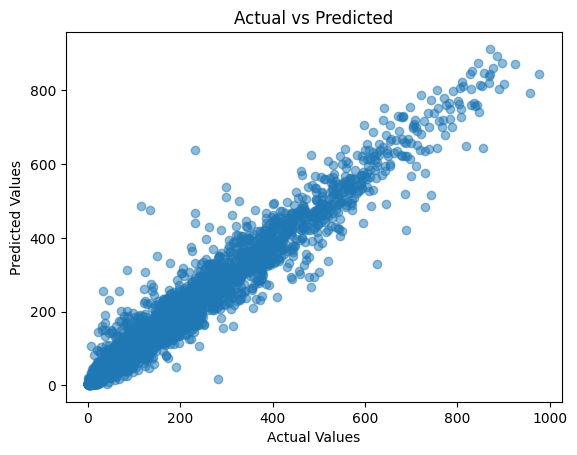

In [255]:
# Step 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

X_train_tensor = X_train.astype({col: 'float32' for col in X_train.select_dtypes('bool').columns})
X_test_tensor = X_test.astype({col: 'float32' for col in X_test.select_dtypes('bool').columns})
y_train_tensor = y_train.values
y_test_tensor = y_test.values

scaler = StandardScaler()
X_train_tensor = scaler.fit_transform(X_train)
X_test_tensor = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.float32).view(-1, 1)

# Step 6: Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input to hidden layer 1
        self.fc2 = nn.Linear(64, 32)         # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(32, 16)         # Hidden layer 2 to hidden layer 3
        self.fc4 = nn.Linear(16, 1)          # Hidden layer 3 to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output layer for regression
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = RegressionModel(input_dim)

# Step 7: Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Train the model
num_epochs = 100
batch_size = 32

# Create data loader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(X_batch)  # Forward pass
        loss = criterion(predictions, y_batch)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Step 9: Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor).item()
    print(f'Test MSE: {test_loss:.4f}')

# Step 10: Make predictions (optional)
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Optional: Plot the actual vs predicted values
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()
